# Cormorant 
---
## Summary
Everyone thinks they're special.  In fact, I feel that no other person has an adequately similar taste in music as I do.  This is probably false, but it does provide an interesting premise for a ML project.

Recommendation systems typically work (or at least used to) by saying Susie likes song A, Betsy likes song A and B, so Susie probably would like song B.  

That's not good enough for a special snowflake like myself, who only likes a very certain type of EDM (at least that's what I'm thinking for the onset).

What I'm going to do instead is make a classifier of song spectrograms to determine features of songs I enjoy.  From there, I'll make a youtube crawler to bring me new music (hence the name Cormorant).

## Plan




1.  Pretraining
    - ImageNet for the base model.
    - Training off the Larger Dataset, then transfering weights over.
    
    
2.  Data
    - Need to convert Youtube Playlists to spectrograms.
    - Train, Test, Validation Sets
    
    

3.  Learning
    - This is a very simple BinaryClassifier (Do I like this music or not?)
    - Or do I want to do Regression for how MUCH I like the song?
    

4.  Action
    - Youtube crawler, with seed keywords, URLs.
    - Some kind of action to determine live learning and updating of the net - will probably end up making minibatches, then updating all at once.
    - Those that pass need to be sent up for review by me somehow - adding to Google Music probably.
    
    
    
### Key Technologies Explored

- Youtube API
- Online learning for a neural network
- Neural network with a smaller dataset



### Useful articles:
- https://towardsdatascience.com/build-any-deep-learning-image-classifier-under-15-lines-of-code-using-fastai-v2-123c81c13b
- https://towardsdatascience.com/using-fastai-for-image-classification-54d2b39511ce
- https://towardsdatascience.com/image-classification-using-fastai-v2-on-colab-33f3ebe9b5a3

---

## Step 0 : Getting a dataset to train on
---
Since the Million Song Dataset seems a bit hard to come by in the 9 years since it was published, we're using `https://github.com/mdeff/fma`.   

Going to use the large dataset, 30s with 100k or so of classified songs.  

Should be easy enough to run the spectrogram on them and classify them. 

In [1]:
import os

In [3]:
!apt update && apt install -y wget

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease                    
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [116 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:6 http://security.ubuntu.com/ubuntu bionic-security/multiverse amd64 Packages [10.1 kB]3m
Get:7 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [1089 kB]33m
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages [901 kB]

In [5]:
!wget https://os.unil.cloud.switch.ch/fma/fma_large.zip

--2020-09-16 05:06:32--  https://os.unil.cloud.switch.ch/fma/fma_large.zip
Resolving os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)... 86.119.28.16, 2001:620:5ca1:201::214
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100306112191 (93G) [application/zip]
Saving to: 'fma_large.zip'

fma_large.zip        33%[=====>              ]  31.35G  9.14MB/s    in 59m 9s  

2020-09-16 06:05:42 (9.05 MB/s) - Connection closed at byte 33662652544. Retrying.

--2020-09-16 06:05:43--  (try: 2)  https://os.unil.cloud.switch.ch/fma/fma_large.zip
Connecting to os.unil.cloud.switch.ch (os.unil.cloud.switch.ch)|86.119.28.16|:443... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 100306112191 (93G), 66643459647 (62G) remaining [application/zip]
Saving to: 'fma_large.zip'

fma_large.zip        67%[++++++======>       ]  62.85G  9.14MB/s    in 59m 19s 

2020-09-16 07:05:03 

### Worries
So I'm a little concerned at this point.  I looked at the Kaggle competition for the Million Song Dataset - the top results were not promising.  Hopefully, since I'm just classifying whether or not I like the song, I can get better results.  If this fails, I'll look back at this moment as the one where the small cloud on the horizon popped up.

I've always been a little concerned that the spectrograms couldn't capture enough subtle differences between songs to make a distinction - i.e. that the signal was too faint to detect.  Since it's very hard to hear a picture (outside of synthesia), it's hard to reason intuitively what the spectrogram actually means.

---

## Step 1: Spectrograms
---
This work is already done in the Cormorant Github repository, so we'll download a copy of that and go from there.

In [ ]:
!apt update && apt -y install git

In [10]:
!git clone https://github.com/amunchet/cormorant.git

Cloning into 'cormorant'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 49 (delta 14), reused 42 (delta 10), pack-reused 0
Unpacking objects: 100% (49/49), done.


In [25]:
!apt install -y unzip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  zip
The following NEW packages will be installed:
  unzip
0 upgraded, 1 newly installed, 0 to remove and 50 not upgraded.
Need to get 167 kB of archives.
After this operation, 558 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 unzip amd64 6.0-21ubuntu1 [167 kB]
Fetched 167 kB in 1s (256 kB/s)0m
debconf: delaying package configuration, since apt-utils is not installed

78Selecting previously unselected package unzip.
(Reading database ... 16385 files and directories currently installed.)
Preparing to unpack .../unzip_6.0-21ubuntu1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [ 17%] [#########.................................................] 8Unpacking unzip (6.0-21ubuntu1) ...
7Progress: [ 33%] [###################.......................................

In [ ]:
!unzip fma_large.zip

## Step 2: Convert training data to spectrogram and move to proper folders
---
Will need to run spectrogram converter on all ~100k files and put them in the proper folders.  

Do we want to multithread this?  FFMPEG can use GPU, but I'm not sure the spectrogramming itself can.

Probably want to do 4 threads (seemed to work well last time).

### More Thoughts
- Our average song length (NCS) is going to be around 3 minutes.  However, I don't want to just train on 30 seconds, when the actual data is going to be around 1-5 minutes.  I think I'm going to randomize and repeat the entries
- This is going to take up quite a bit of space.  I better check that it's okay.

In [2]:
pip install scipy

    100% |################################| 25.9MB 83kB/s  eta 0:00:011
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.io.wavfile as wav
from numpy.lib import stride_tricks
import os

In [14]:
ls /mnt/sdf/fma_large/000 | head -n 20

000002.mp3
000003.mp3
000005.mp3
000010.mp3
000020.mp3
000026.mp3
000030.mp3
000046.mp3
000048.mp3
000134.mp3
000135.mp3
000136.mp3
000137.mp3
000138.mp3
000139.mp3
000140.mp3
000141.mp3
000142.mp3
000144.mp3
000145.mp3


In [16]:
cd phase_one

/data/Cormorant/cormorant/phase_one


In [18]:
cp /mnt/sdf/fma_large/000/000002.mp3 .

In [19]:
ls

000002.mp3  cormorant.py*  requirements.txt  spider/
README.md   generator/     spectrogram.py*


In [28]:
!apt update && apt install -y cython

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease          
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease                
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Reading package lists... Done                  
Building dependency tree       
Reading state information... Done
All packages are up to date.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cython is already the newest version (0.26.1-0.4).
0 upgraded, 0 newly installed, 0 to remove 

### Installing Librosa
This requires llvm-10 to be installed.  That is a pain and requires symlinking `llvm-config` in the path.

#### Final conclusion: Librosa installation is horrible.  Going to convert all files to wav instead - way easier.  Which is insane.

### Step 2A: Converting mp3 files to wav

So the way that I did this in OneTrickFan was to use a `ffmpeg` docker with Nvidia runtime.  Several problems have emerged, however.  The primary being that the MP3 compression is very efficient and the WAV is not - meaning my disk usage will increase by about 20x.  

This means that I will instead have to in-place generate the spectrograms all in one shot - cleaning up any wav files I leave behind.

This is done in the `phase_one`/`converter` folder, using `full.py`

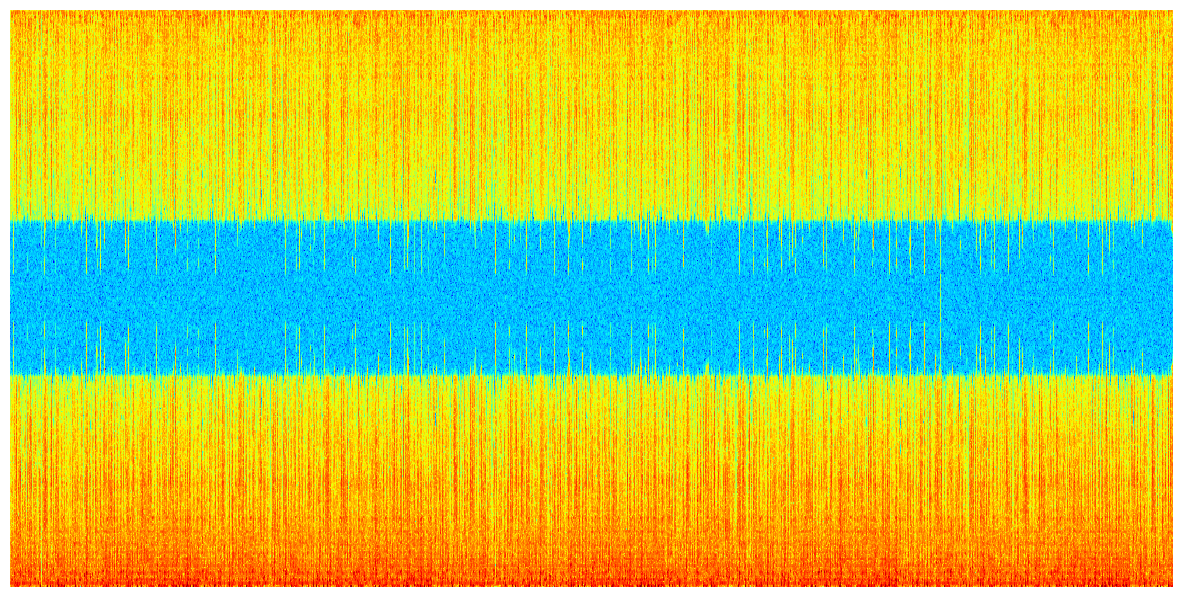

In [10]:
from IPython.display import Image
Image(filename='/mnt/sdf/fma_large/000/000002.mp3.png') 

### Step 2B: Sorting spectrograms into folders for training

We need to read in from the CSV file and organize the generated spectrograms into their proper labels.


This ended up being done in the `organizer` portion of `phase_one` folder in the repo.

---



## Step 3: Initial Model training with spectrograms from large Dataset

One of the main questions is: which to use - Tensorflow or FastAI? - **FastAI**

I think I'll still use one of the larger ImageNets for transfer learning, so FastAI.  I should then be able to train on the large dataset, then transfer over to the much smaller actual dataset.

I don't really have a need to do an AutoEncoder, since this is pretty well labelled dataset that I'll be transfer learning off.

### Step 3A: Training on a subset of the whole dataset

I want to make sure that I'm on somewhat the right track with my pre-training before I go converting all the mp3 files.

I also might end up deleting the original MP3 files from the dataset to conserve space - I definitely want to make sure we have a viable plan before doing that.

In [11]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [12]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
pip install --no-cache-dir fastai

     |################################| 190 kB 7.0 MB/s eta 0:00:01
     |################################| 52 kB 15.0 MB/s eta 0:00:01
     |################################| 776.8 MB 21.1 MB/s eta 0:00:01     |######                          | 150.5 MB 19.1 MB/s eta 0:00:33     |#######                         | 183.8 MB 10.5 MB/s eta 0:00:57     |#######################         | 566.8 MB 19.0 MB/s eta 0:00:12
     |################################| 12.8 MB 11.0 MB/s eta 0:00:01
     |################################| 9.5 MB 13.1 MB/s eta 0:00:01     |###########                     | 3.3 MB 13.1 MB/s eta 0:00:01
     |################################| 510 kB 17.7 MB/s eta 0:00:01
     |################################| 10.4 MB 15.9 MB/s eta 0:00:01
     |################################| 9.8 MB 18.1 MB/s eta 0:00:01
     |################################| 126 kB 20.5 MB/s eta 0:00:01
     |################################| 184 kB 26.5 MB/s eta 0:00:01
     |########################

In [1]:
import fastai
fastai.__version__

'2.1.10'

In [2]:
import torch

print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


0
1
GeForce RTX 2070
True


In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.vision import *
from fastai.vision.all import *
from fastai.metrics import accuracy

In [4]:
DIR="/mnt/sdf/data/"
size = 512
bs = 8
DATASET_PATH = Path(DIR)

In [5]:
import os
labels = os.listdir(DIR)
print("No. of labels: {}".format(len(labels)))
print("-----------------")

for label in labels:
    print("{}, {} files".format(label, len(os.listdir(DIR+label))))

No. of labels: 16
-----------------
Spoken, 75 files
Avant-Garde, 4 files
Pop, 6 files
Psych-Folk, 3 files
Improv, 4 files
Experimental, 101 files
Lo-Fi, 1 files
Soul-RnB, 42 files
Folk, 80 files
Hip-Hop, 32 files
Rock, 278 files
Blues, 5 files
Experimental Pop, 13 files
Jazz, 28 files
International, 9 files
Electronic, 66 files


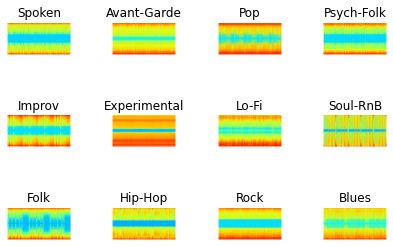

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig, ax = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()
cnt = 0
for row in ax:
    for col in row:
        image_name = np.random.choice(os.listdir(DIR + labels[cnt]))
        im = Image.open("{}{}/{}".format(DIR,labels[cnt],image_name))
        col.imshow(im)
        col.set_title(labels[cnt])
        col.axis('off')
        cnt += 1
plt.show()

In [7]:
 datablock = DataBlock(
           get_items=get_image_files,
           get_y=parent_label,
           blocks=(ImageBlock, CategoryBlock), 
           splitter=RandomSplitter(valid_pct=0.2, seed=100)
        )

In [20]:
dls = datablock.dataloaders(DATASET_PATH, bs=bs, size=size)

Since FastAI updated majorly since I last used it, I'm going to be following along with this: https://towardsdatascience.com/build-any-deep-learning-image-classifier-under-15-lines-of-code-using-fastai-v2-123c81c13b

In [21]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

In [22]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,3.272078,2.010499,0.496644,00:26


epoch,train_loss,valid_loss,error_rate,time
0,2.312933,1.727109,0.489933,00:33
1,1.996501,1.769462,0.469799,00:33
2,1.456395,1.581053,0.375839,00:33
3,0.941342,1.624272,0.389262,00:34


SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=1.0964781722577754e-06)

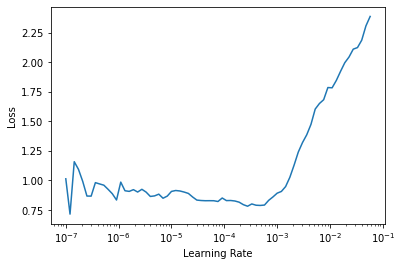

In [23]:
learn.lr_find()

Let's look at some of the data batches to make sure things are going as planned.


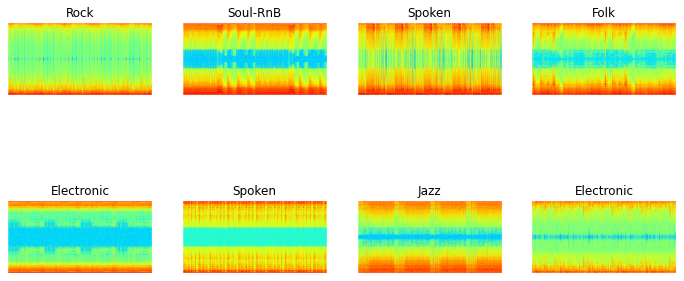

In [16]:
dls.show_batch()

In [25]:
xb, yb = dls.one_batch()
print(xb.shape, yb.shape)

torch.Size([8, 3, 597, 1182]) torch.Size([8])


In [17]:
interp = ClassificationInterpretation.from_learner(learn)

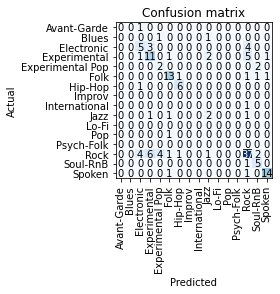

In [18]:
interp.plot_confusion_matrix()

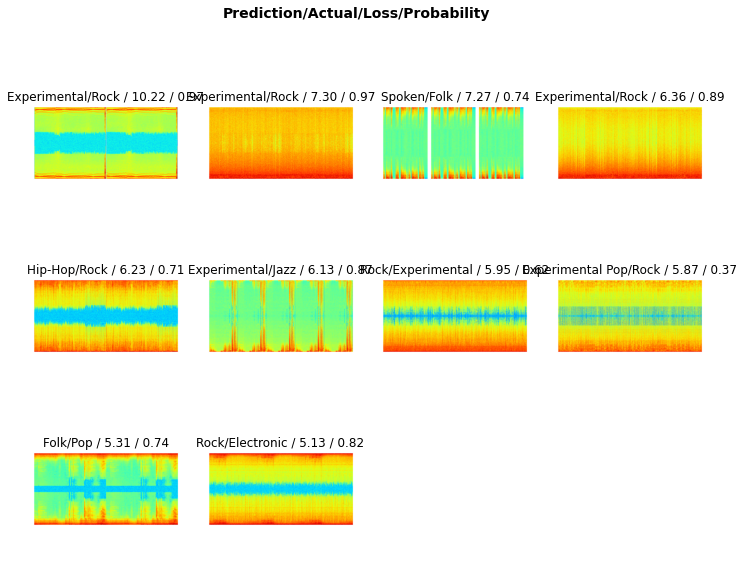

In [28]:
interp.plot_top_losses(10)

### Current State
Right now the model's performance isn't good.  Not surprising, since we have have a very high ratio of labels to data.  This looks good enough to compile the rest of the data and continue the pre-training.

## Step 3B: Pre-Training on Full Dataset

For this, we'll need to run the spectrogram conversion and file movement for folders in the `fma_large` dataset

---



## Step 4: Dataset splitting - songs I like/don't

## Step 5: Binary Classifier on Songs

### Step 5a: Data verification and spot checking

## Step 6: Youtube API exploration and crawling
- I've done this in spider


## Step 7: Online Learning/Updating a neural net

So what I'm actually thinking of doing is having batches of songs presented, then graded.  After grading, they'll be added to the data collection of spectrograms and then have a new model trained.  Then a new batch of top song prospects will be brought in, and so on, and so forth.

Eventually, there should be a large enough dataset to give good results.

This isn't exactly "online" learning, but it is incremental, automated improvements of the model.